# Lab 2: Convolution & Discrete Fourier Transform

In [12]:
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray, rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Edges
from skimage.filters import sobel_h, sobel, sobel_v, roberts, prewitt

# Show the figures / plots inside the notebook

In [13]:
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12, 8))
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X, Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()


def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)

    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq)+1))
    filtered_img_in_freq = fftpack.fftshift(
        np.log(np.abs(filtered_img_in_freq)+1))

    show_3d_image(img_in_freq, 'Original Image')
    show_3d_image(filtered_img_in_freq, 'Filtered Image')


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)

    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


# Show the matlpotlib figures inside the notebook
%matplotlib inline

##### Helper functions:
cf.show_images(images, titles=None)
<br>
Given a list of images and -(optionally)- a list of titles, it plots them using matplotlib with their respective titles 

### Part 1
#### Understanding the Concept of Inverse DFT

In this part, we will construct matrices in the frequency domain and see how they look in the 2D space domain

In [14]:
# This function maps matrices from frequency to space then plots them
def plot_image_from_freq(freq_domain_mat):
    inverse_fft_mat = fftpack.ifft2(freq_domain_mat) # Inverse FFT is a fast version of inverse DFT
    # Due to approximations, the returned matrix contains complex numbers
    # So, we get the magnitude to be able to plot the image
    image = np.abs(inverse_fft_mat) 
    show_images([image], titles=['Image in Space Domain'])

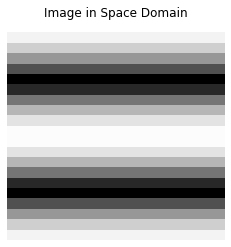

In [15]:
# We will first try to construct a matrix in the frequency domain that makes a vertically moving ripple in the space domain

freq_domain_mat = np.zeros([21,21])
freq_domain_mat[9, 10] = 1 # The choice of the value '1' is arbitrary
freq_domain_mat[11, 10] = 1
plot_image_from_freq(freq_domain_mat)

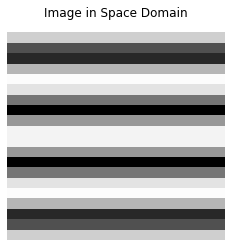

In [16]:
# TODO: construct a matrix in the frequency domain that makes a HORIZONTALLY moving ripple in the space domain

freq_domain_mat = np.zeros([21,21])
freq_domain_mat[12, 10] = 1
freq_domain_mat[8, 10] = 1
plot_image_from_freq(freq_domain_mat)

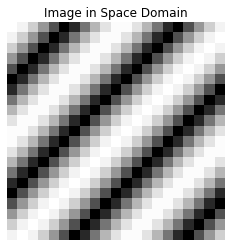

In [17]:
# Now a ripple moving diagonally
freq_domain_mat = np.zeros([21,21])
freq_domain_mat[9, 9] = 1
freq_domain_mat[11, 11] = 1
plot_image_from_freq(freq_domain_mat)

We recommend you try to construct different matrices like the previous ones and see if their space domain representation is what you expect

### Part 2
#### Understanding Image Filtering in the Frequency Domain

In this part, we will try to alter an image by multiplying it by a filter in the frequency domain.

In [18]:
# This function applies a filter to an image in the frequency domain
# and plots multiple images describing the process
def apply_filter_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    
    # we supply the img shape here to make both the filter and img have the same shape to be able to multiply
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)
    filtered_img = fftpack.ifft2(filtered_img_in_freq)
    
    show_images([img,
                fftpack.fftshift(np.log(np.abs(img_in_freq)+1)), # log for better intensity scale, 
                                                                 # shift to make zero freq at center
                fftpack.fftshift(np.log(np.abs(filter_in_freq)+1)),
                fftpack.fftshift(np.log(np.abs(filtered_img_in_freq)+1)),
                np.abs(filtered_img)
                ], ['Image', 'Image in Freq. Domain', 'Filter in Freq. Domain', 'Filtered Image in Freq. Domain', 'Filtered Image'])

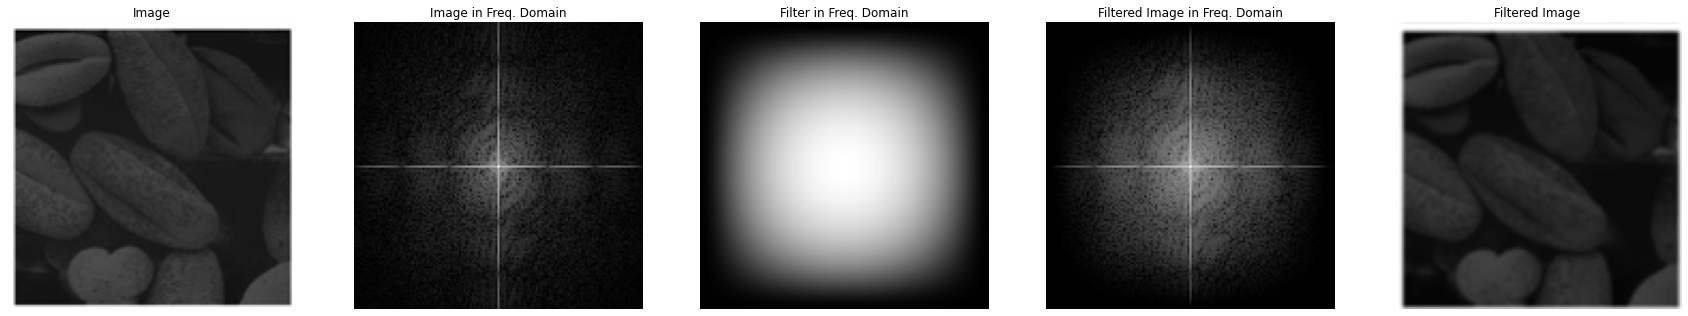

In [19]:
# Let's try some filters on a sample image
img = rgb2gray(io.imread('imgs/Picture2.png')[:,:,:3])

# This is a low pass filter (more on that in the upcoming lectures)
f=np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

apply_filter_in_freq(img, f)

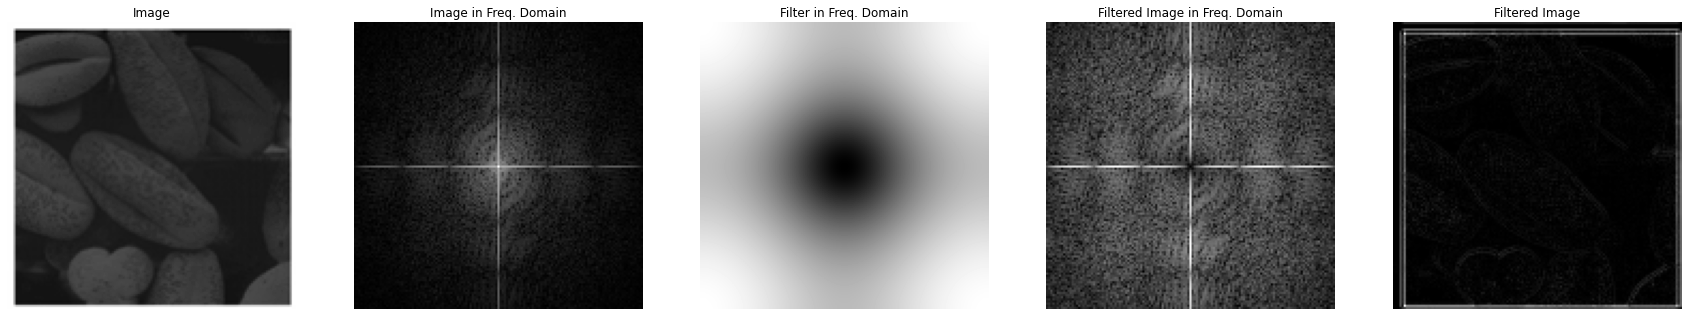

In [20]:
# This is a high pass filter (more on that in the upcoming lectures)
f=np.array([
    [ 0,-1, 0],
    [-1, 4,-1],
    [ 0,-1, 0]
])

apply_filter_in_freq(img, f)

#### TODO
What happened to the filtered images in the two previous examples and why?

/tmp/ipykernel_49597/541127370.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


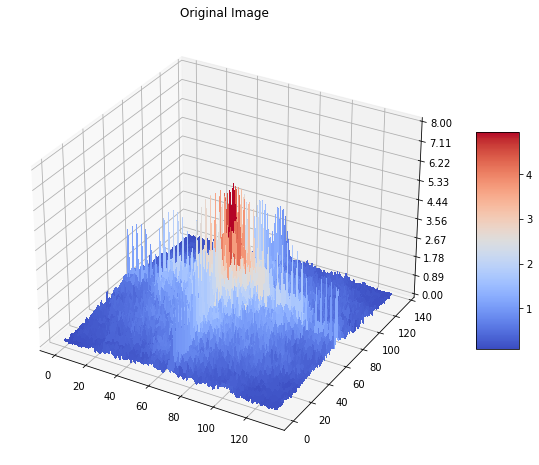

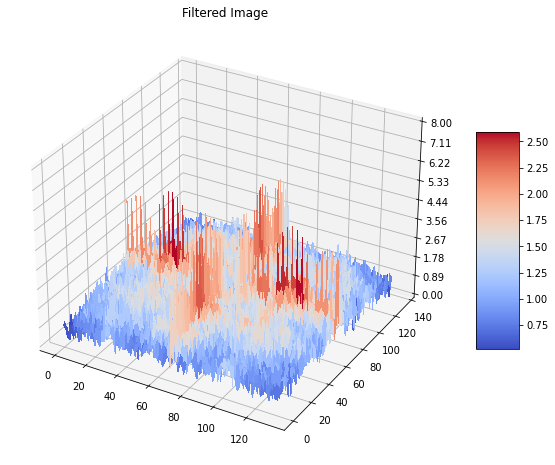

In [21]:
show_3d_image_filtering_in_freq(img, f)

### Part 3
#### Understanding Image Filtering in the Space Domain Through Convolution 

In this part, you are required to convolve a couple of filters on imgs/bird.jpg which are shown in the next figure.

<img src='imgs/filters.PNG'></img>

#### Functions you might need:
-> convolve2d(img, f), for documentation: <br>

Visit this link (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)
<br>
Or
<br>
Press shift+tab after writing 'convolve2d' in a code cell

-> random_noise(img, mode) (https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.random_noise)

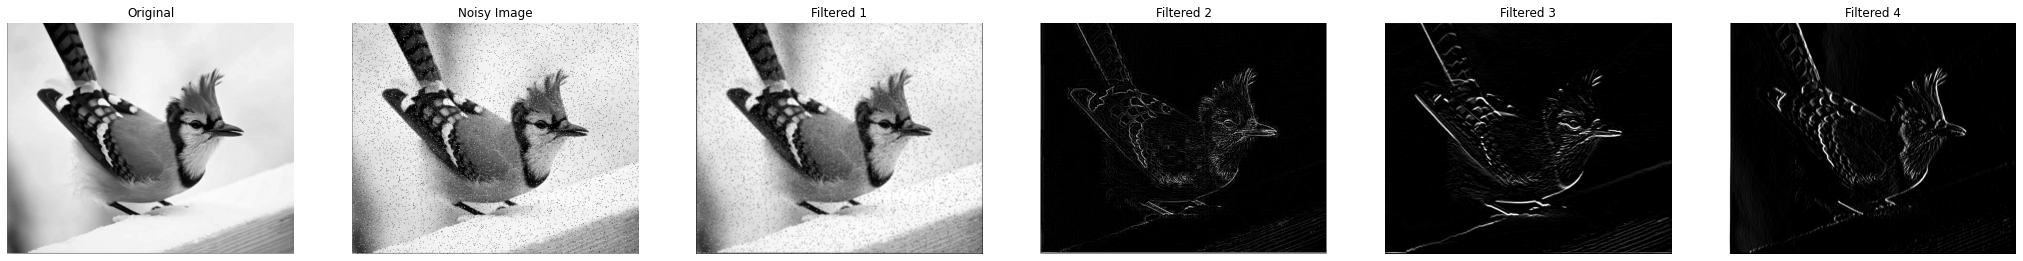

In [22]:
# TODO: Read an image and convert it to grayscale
img = rgb2gray(io.imread("./imgs/bird.jpg"))

# TODO: Apply noise to the image and save it in another variable
noisy_img = random_noise(img, mode="s&p", salt_vs_pepper=0.5)

# TODO: Construct the required filters (hint: you can do it as we did in the previous part)
f1 = np.array([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
], dtype=float)

f2 = np.array([
    [1, 1, 1],
    [1, -8, 1],
    [1, 1, 1]
])

f3 = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
])

f4 = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

# TODO: Convolve the noisy image with f1 and the rest of the filters with the original image
img_f1 = convolve2d(noisy_img, f1)
img_f2 = convolve2d(img, f2)
img_f3 = convolve2d(img, f3)
img_f4 = convolve2d(img, f4)


# Show the images
show_images([rescale_intensity(x, in_range=(0.0,1.0), out_range=(0, 255)) for x in [img,noisy_img, img_f1,img_f2,img_f3,img_f4]],['Original','Noisy Image', 'Filtered 1','Filtered 2','Filtered 3','Filtered 4'])